In [1]:
from datasets import load_dataset
#Installing datasets library to access CORD dataset

In [2]:
%matplotlib inline
#inline magic command to make sure all pictures are in line with each cell

#Installing libraries
print("INSTALLING LIBRARIES....")
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import matplotlib.patches as patches
import random
print("LIBRARIES INSTALLED!")

INSTALLING LIBRARIES....
LIBRARIES INSTALLED!


In [3]:
print("DOWNLOADING CORD DATASET...")
cord_dataset = load_dataset("naver-clova-ix/cord-v2")
print("CORD DATASET DOWNLOADED!")
print("Cord dataset type: ", type(cord_dataset))

DOWNLOADING CORD DATASET...


Using custom data configuration naver-clova-ix--cord-v2-c97f979311033a44
Found cached dataset parquet (/Users/piriyan_karu/.cache/huggingface/datasets/naver-clova-ix___parquet/naver-clova-ix--cord-v2-c97f979311033a44/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/3 [00:00<?, ?it/s]

CORD DATASET DOWNLOADED!
Cord dataset type:  <class 'datasets.dataset_dict.DatasetDict'>


In [4]:
#Initialising train, val and test datasets
print("SEPARATING DATASET INTO TRAIN, VALIDATION AND TEST...")
train, val, test = cord_dataset["train"], cord_dataset["validation"], cord_dataset["test"]
print("DATASET SEPERATED!")

SEPARATING DATASET INTO TRAIN, VALIDATION AND TEST...
DATASET SEPERATED!


# Pre-processing data from training, validation and testing datasets
### Initially checking data format
### Seperating target data needed

In [5]:
#Seperating images
train_images = train['image']
train_labels = train['ground_truth']

#plt.figure((10,10))
for i in range(9):
    img = np.array(train_images[i])
    plt.subplot(3,3,i+1)
    plt.imshow(img, cmap='gray')
    plt.title(img.shape)
    plt.axis('off')

A label for training data when evaluated using **eval** function gives the following keys:
'gt_parse', 'meta', 'valid_line', 'roi', 'repeating_symbol', 'dontcare'

We do not need: 'roi', 'repeating_symbol' and 'dontcare

gt_parse: Tells us information that we do not need for the problem of region detection
meta: Tells us information such as width, height, id of image
valid_line: **IMPORTANT** for this problem as it gives us all the coordinates of each text point in image

"""
def keyRep(lables, key_str):
    print(key_str.upper() + ":")
    print(lables[key_str])
    print("************************************************")
    

keyRep(a_label, "gt_parse")
keyRep(a_label, "meta")
keyRep(a_label, "valid_line")
"""

**CURRENT PROBLEM:** Detect dense regions in given receipt

In order to tackle this problem, we need to process the given coordinates into the following format for each image (min x1, min y1, max x3, max y3)

Each element of valid line has the following keys: words, category, group_id, sub_group_id

words: contains the coordinates
- Each element of words contain keys: quad, is_key, row_id, text
- quad: contains the actual coordinates
- text: contains the text at given coordinate

In [6]:
IMG_SIZE = 512

In [7]:
print("Defining function to retreive [x1, y1, x3, y3] coordinates of each datapoint")

def retreiveCoordinates(labels):
    coords = []
    vline = labels["valid_line"]
    #Using a nested loop to get all coordinates for given label
    for line in vline: #run through n lines for label
        words = line['words']
        for word in words: #run through n words in each line and retreive the coordinates of said word
            quad = word['quad']
            box = [quad['x1'], quad['y1'], quad['x3'], quad['y3']]
            coords.append(box)
    
    return coords

Defining function to retreive [x1, y1, x3, y3] coordinates of each datapoint


In [8]:
print("Defining function to get (min x1, min y1, max x3, max y3)")

def denseBoxCoord(label):
    coords = retreiveCoordinates(label)
    x1 = [coord[0] for coord in coords] #Get all x1
    y1 = [coord[1] for coord in coords] #Get all y1
    x3 = [coord[2] for coord in coords] #Get all x3
    y3 = [coord[3] for coord in coords] #Get all y3
    
    PAD = 20 #pad the bounding boxes to get dense box
    
    denseBox = [min(x1)-PAD, min(y1)-PAD, max(x3)+PAD, max(y3)+PAD] #define the dense bounding box
    return denseBox

Defining function to get (min x1, min y1, max x3, max y3)


In [9]:
print("Defining a displaying function to display images with dense box on them")

def showDBox(img_index):
    img = train_images[img_index]
    img_label = eval(train_labels[img_index])
    width, height = img_label['meta']['image_size']['width'], img_label['meta']['image_size']['height']
    dBox_img = denseBoxCoord(img_label)
    fig, ax = plt.subplots() #make a subplot

    ax.imshow(img) #draw the image on the axis of the subplots
    x1 = dBox_img[0]
    y1 = dBox_img[1]
    x3 = dBox_img[2]
    y3 = dBox_img[3]
    rect = patches.Rectangle((x1, y1), (x3-x1), (y3-y1), linewidth=1, edgecolor='r', facecolor='none')
    #Draw a rectangle using bounding boxes 
    ax.add_patch(rect)

    plt.title("WxH: ({0},{1}) | {2}".format(width, height, dBox_img))
    plt.axis('off')
    plt.show()

Defining a displaying function to display images with dense box on them


In [10]:
print("Defining pre-process function for images")

def flatten_list(list_imgs):
    return [img_data for data_list in list_imgs for img_data in data_list]

def pre_process_images(images):
    #resize images and then change them into an np array
    new_images = [[img_to_array(image.resize((IMG_SIZE,IMG_SIZE)))] * 2 for image in images]

    new_images = flatten_list(new_images)
    #normalize the values of the arrays
    new_images = np.array(new_images, dtype='float32') / 255.0
    return new_images

Defining pre-process function for images


In [12]:
def inter_over_union(dBoxA, dBoxB):
    inter_x1 = max(dBoxA[0], dBoxB[0])
    inter_y1 = max(dBoxA[1], dBoxB[1])
    inter_x3 = min(dBoxA[2], dBoxB[2])
    inter_y3 = min(dBoxA[3], dBoxB[3])
    
    if (inter_x3 < inter_x1) or (inter_y3 < inter_y1):
        return 0
    
    inter_area = (inter_x3 - inter_x1) * (inter_y3 - inter_y1)
    
    union_A = (dBoxA[2] - dBoxA[0]) * (dBoxA[3] - dBoxA[1])
    union_B = (dBoxB[2] - dBoxB[0]) * (dBoxB[3] - dBoxB[1])
    
    union_area = (union_A + union_B) - inter_area
    
    return (inter_area / union_area)
    
    
    
    

In [13]:
# Returns a list of random numbers given a value
# Used to randomly return a list of coordinates given the width/height of an image as a base
def genListRandNumber(max_val):
    
    list_of_vals = []
    while len(list_of_vals) < 3:
        list_of_vals = [random.randint(0, max_val) for i in range(10)]
        list_of_vals = list(set(list_of_vals))
    
    return list_of_vals

# Returns a randomly generated DBox
# Used to get a negative class (0) DBox for an image
def getNegDBox(width, height):
    xs = genListRandNumber(width)
    ys = genListRandNumber(height)
    
    x1, y1 = min(xs), min(ys)
    x3, y3 = max(xs), max(ys)
    
    return [x1, y1, x3, y3]

# Generates the negative class (0) DBox given the positive class DBox(1) using Intersection-over-Union method
def generateNegBox(dBox, width, height, norm=False):
    negBox = [0,0,0,0]
    iou = 1
    
    while iou > 0.3:
        negBox = getNegDBox(width, height)
        iou = inter_over_union(dBox, negBox)
    
    if norm:
        negBox_norm = [
            negBox[0] / width,
            negBox[1] / height,
            negBox[2] / width,
            negBox[3] / height
        ]
        
        return negBox_norm
    
    return negBox
    
    

In [14]:
print("Defining pre-process function for labels")

def pre_process_label(label):
    pos_and_negs = []
    conf_scores = []
    ev_lab = eval(label)
    width, height = ev_lab['meta']['image_size']['width'], ev_lab['meta']['image_size']['height']
    dBox = denseBoxCoord(ev_lab)
    #normalize the dbox coordinates using original width and height such that the values are between 0 and 1
    pos_labels = [
        dBox[0] / width,
        dBox[1] / height,
        dBox[2] / width,
        dBox[3] / height
           ]

    
    pos_and_negs.append(pos_labels) #Adding the positive (correct dBox coordinates) sample | 1 denotes correct dBox
    conf_scores.append(1)
    negBox = generateNegBox(dBox, width, height, norm=False)
    
    neg_labels = [
        negBox[0] / width, 
        negBox[1] / height, 
        negBox[2] / width, 
        negBox[3] / height
    ]
    

    pos_and_negs.append(neg_labels)
    conf_scores.append(0)
        
    return pos_and_negs, conf_scores

def pre_process_labels(labels):
    new_labels = []
    confScores = []
    for label in labels:
        #pre-process each label
        nLabel, confScore = pre_process_label(label)
        new_labels.extend(nLabel)
        confScores.extend(confScore)
        
    new_labels = np.array(new_labels)
    confScores = np.array(confScores)
    
    return new_labels, confScores

Defining pre-process function for labels


In [15]:
print("Pre-processing the datasets...")

tImages, (tLabels, tgLabels) = pre_process_images(train_images), pre_process_labels(train_labels)

print("Training Data: Processed")

Pre-processing the datasets...
Training Data: Processed


In [16]:
tLabels[0]

array([0.24537037, 0.26388889, 0.77430556, 0.91203704])

In [ ]:
vImages, vLabels = pre_process_images(val['image']), pre_process_labels(val['ground_truth'])

print("Validation Data: Processed")

In [195]:
# Need to solve final training dataset problem

# Model

In [17]:
#CORE CONSTANTS
IMG_INDEX = 1 #Min is 0, Max is 799
BATCH = 64
EPOCHS = 10
L_RATE = 0.001

In [18]:
training_dataset = tf.data.Dataset.from_tensor_slices((tImages,(tgLabels, tLabels)))

2023-01-19 14:08:44.733689: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
training_dataset = training_dataset.shuffle(buffer_size=len(tImages))
training_dataset = training_dataset.batch(BATCH)
training_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None, 4), dtype=tf.float64, name=None)))>

In [20]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [108]:
# Defining the input layer
input_layer = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Using vgg16 as the feature extractor
vgg16_model = VGG16(weights="imagenet", include_top=False, input_tensor=input_layer)

In [109]:
# Defining the region proposal layer
x = vgg16_model.output
x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D()(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

# Defining the output layers for the objectness score and the bounding box coordinates
objectness = Dense(1, activation='sigmoid', name='objectness')(x)
bbox_coords = Dense(4, activation='linear', name='bbox_coords')(x)

# Create the RPN model
model = keras.Model(inputs=input_layer, outputs=[objectness, bbox_coords])

# Compile the model
model.compile(optimizer='adam', loss=['binary_crossentropy', 'mse'], metrics=['accuracy'])

In [111]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 16, 16, 512)       14714688  
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 512)       2359808   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 512)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 512)         2359808   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 512)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 8192)             

In [57]:
history2 = model.fit(training_dataset, batch_size=BATCH, epochs=5)

Epoch 1/5
25/25 [==============================] - 3530s 141s/step - loss: 0.7248 - objectness_loss: 0.6951 - bbox_coords_loss: 0.0297 - objectness_accuracy: 0.4812 - bbox_coords_accuracy: 0.5738
Epoch 2/5
25/25 [==============================] - 3544s 142s/step - loss: 0.7237 - objectness_loss: 0.6943 - bbox_coords_loss: 0.0295 - objectness_accuracy: 0.4944 - bbox_coords_accuracy: 0.5800
Epoch 3/5
25/25 [==============================] - 3524s 141s/step - loss: 0.7245 - objectness_loss: 0.6954 - bbox_coords_loss: 0.0291 - objectness_accuracy: 0.4756 - bbox_coords_accuracy: 0.6012
Epoch 4/5
25/25 [==============================] - 3834s 152s/step - loss: 0.7229 - objectness_loss: 0.6940 - bbox_coords_loss: 0.0289 - objectness_accuracy: 0.5038 - bbox_coords_accuracy: 0.5919
Epoch 5/5
25/25 [==============================] - 3531s 141s/step - loss: 0.7237 - objectness_loss: 0.6953 - bbox_coords_loss: 0.0284 - objectness_accuracy: 0.4969 - bbox_coords_accuracy: 0.6037


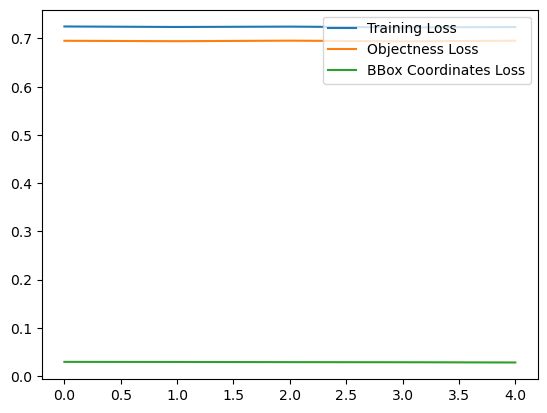

In [65]:
epochs_range = range(5)

plt.plot(epochs_range, history2.history["loss"], label='Training Loss')
plt.plot(epochs_range, history2.history["objectness_loss"], label='Objectness Loss')
plt.plot(epochs_range, history2.history["bbox_coords_loss"], label='BBox Coordinates Loss')
plt.legend(loc='upper right')
plt.show()

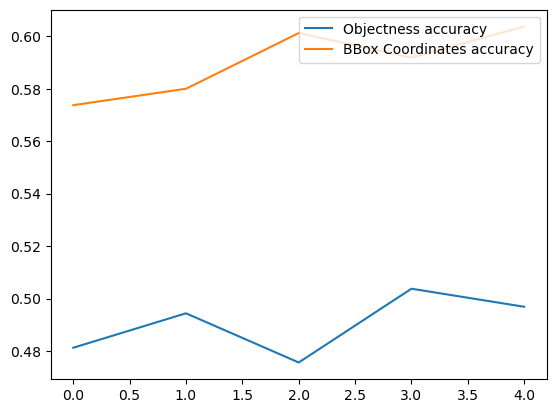

In [66]:
plt.plot(epochs_range, history2.history["objectness_accuracy"], label='Objectness accuracy')
plt.plot(epochs_range, history2.history["bbox_coords_accuracy"], label='BBox Coordinates accuracy')
plt.legend(loc='upper right')
plt.show()

In [62]:
history2.history

{'loss': [0.7247774600982666,
  0.7237442135810852,
  0.7244940400123596,
  0.7228601574897766,
  0.7236596941947937],
 'objectness_loss': [0.6951236724853516,
  0.6942737102508545,
  0.6953981518745422,
  0.6939756274223328,
  0.6952722072601318],
 'bbox_coords_loss': [0.02965385653078556,
  0.029470613226294518,
  0.029095834121108055,
  0.028884582221508026,
  0.028387509286403656],
 'objectness_accuracy': [0.48124998807907104,
  0.49437499046325684,
  0.47562500834465027,
  0.5037500262260437,
  0.49687498807907104],
 'bbox_coords_accuracy': [0.5737500190734863,
  0.5799999833106995,
  0.6012499928474426,
  0.5918750166893005,
  0.6037499904632568]}

checkpoint = ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=True,
    monitor="val_loss",
    mode="min",
    save_best_only=True
) 

In [48]:

def test_image(idx):
    test_data = test['image'][idx]
    tl = eval(test['ground_truth'][idx])
    w,h = tl['meta']['image_size']['width'], tl['meta']['image_size']['height']

    test_data = img_to_array(test_data.resize((IMG_SIZE,IMG_SIZE)))
    test_data = np.expand_dims(test_data, axis=0)
    
    preds = model.predict(test_data)
    
    isPos, dBox = preds
    isPos = isPos[0][0]
    print(isPos)
    
    x1, y1, x3, y3 = dBox[0]
    x1 = int(x1 * w)
    y1 = int(y1 * h)
    x3 = int(x3 * w)
    y3 = int(y3 * h)
    box = [x1,y1,x3,y3]
    
    pred_image = test['image'][idx]
    
    fig, ax = plt.subplots()

    ax.imshow(pred_image)
    rect = patches.Rectangle((x1, y1), (x3-x1), (y3-y1), linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect)
    
    gt_bbox = denseBoxCoord(tl)
    iou = inter_over_union(gt_bbox, box)

    plt.title("WxH: ({0},{1}) | {2} | IOU: {3}".format(w, h, box, iou))
    plt.axis('off')
    plt.show()

1/1 [==============================] - 1s 528ms/step
0.49813497


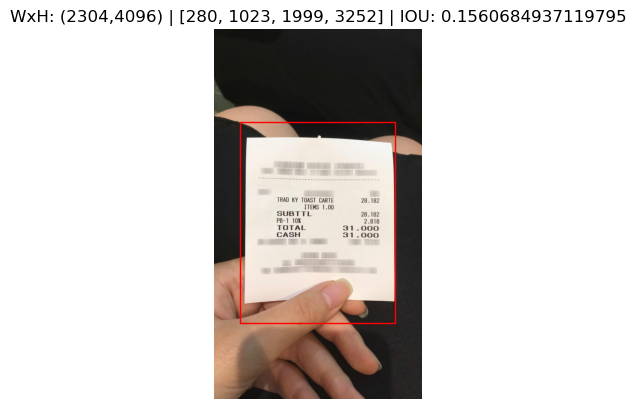

In [49]:
test_image(5)

1/1 [==============================] - 1s 531ms/step
0.3732051


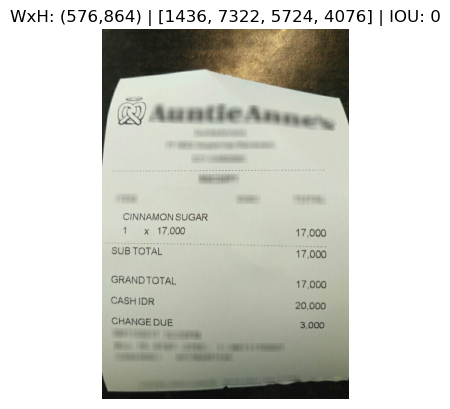

In [50]:
test_image(10)

1/1 [==============================] - 1s 531ms/step
0.49813497


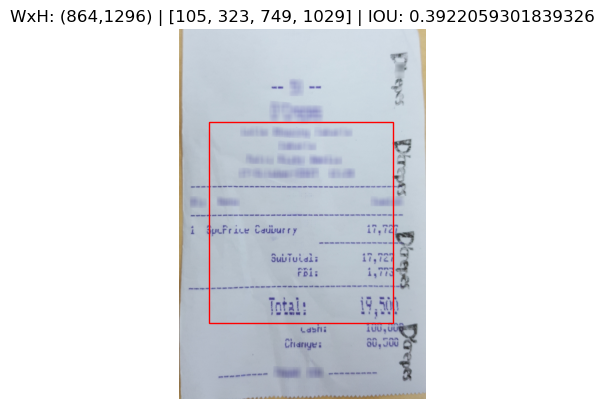

In [51]:
test_image(50)

1/1 [==============================] - 1s 535ms/step
0.49813497


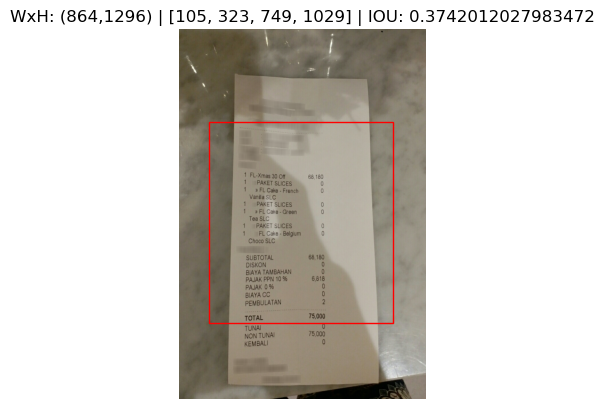

In [53]:
test_image(99)

In [23]:
#model.save("./Save-Models/Initial-Base-Model/")

INFO:tensorflow:Assets written to: ./Save-Models/Initial-Base-Model/assets


INFO:tensorflow:Assets written to: ./Save-Models/Initial-Base-Model/assets
